# Dataloading

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import pandas as pd

from qscaled.wandb_utils.one_seed_per_run import ExampleOneSeedPerRunCollector
from qscaled.utils.zip_handler import fetch_zip_data
from qscaled.utils.configs import SweepConfig
from qscaled.core.preprocessing import bootstrap_crossings

from qscaled.core.grid_search.learning_curves import (
    plot_per_learning_rate,
    plot_per_batch_size,
)

from qscaled.core.grid_search.bootstrap_envsteps_to_thresh import (
    grid_best_uncertainty_lr,
    grid_best_uncertainty_bs,
    get_bootstrap_optimal,
    compute_bootstrap_averages,
    plot_bootstrap_average_params,
)

from qscaled.core.grid_search.linear_fit import (
    make_linear_fit_separate_slope,
    make_linear_fit_shared_slope,
    tabulate_proposed_hparams_separate_slope,
    tabulate_proposed_hparams_shared_slope,
    tabulate_baseline_hparams,
    plot_fits_against_grid_separate_slope,
    plot_fits_against_grid_shared_slope,
)

from qscaled.core.grid_search.data_efficiency import (
    plot_closest_data_efficiency,
    plot_averaged_data_efficiency,
)

np.random.seed(42)

To use this code on your own data:
1. Label your Wandb runs with tags.
2. Fill in `MyRunCollector` in `utils/wandb_utils.py`.
3. Update the following cell.

The latter two steps take ~10 minutes!

If you set `wandb_collect == True`, your `zip` file will be rebuilt using your
Wandb collector. Otherwise, the `zip` file must be present.

In [55]:
wandb_collect = False

if wandb_collect:
    wandb_collector = ExampleOneSeedPerRunCollector('prestonfu', 'crl', wandb_tags=['sac_grid_manual_250206'])
    # Remove these lines if you'd like
    wandb_collector.remove_short(0.95)
    wandb_collector.trim(num_seeds=8, returns_key='episode/return', verbose=True)
else:
    wandb_collector = None

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is some variation for different environments.

config = SweepConfig(
    name='gym_sweep',
    max_returns={
        'HalfCheetah-v4': 7300 * 1.25,
        'Walker2d-v4': 4000 * 1.25,
        'Ant-v4': 5300 * 1.25,
        'Humanoid-v4': 5200 * 1.25,
    },
    returns_key='episode/return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16],
    wandb_collector=wandb_collector,
)

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

If you used the code above with `save_loop`, use `UTDGroupedLoader` below.
(`FullGroupedLoaderUnlabeled` is used below for DMC data, which was collected independently.)

In [56]:
grid_search_df = fetch_zip_data(config, use_cached=True)
grid_search_df = bootstrap_crossings(grid_search_df, config.thresholds, filename=config.name)

Average standard deviation across all conditions: 2771.15


# Visualization

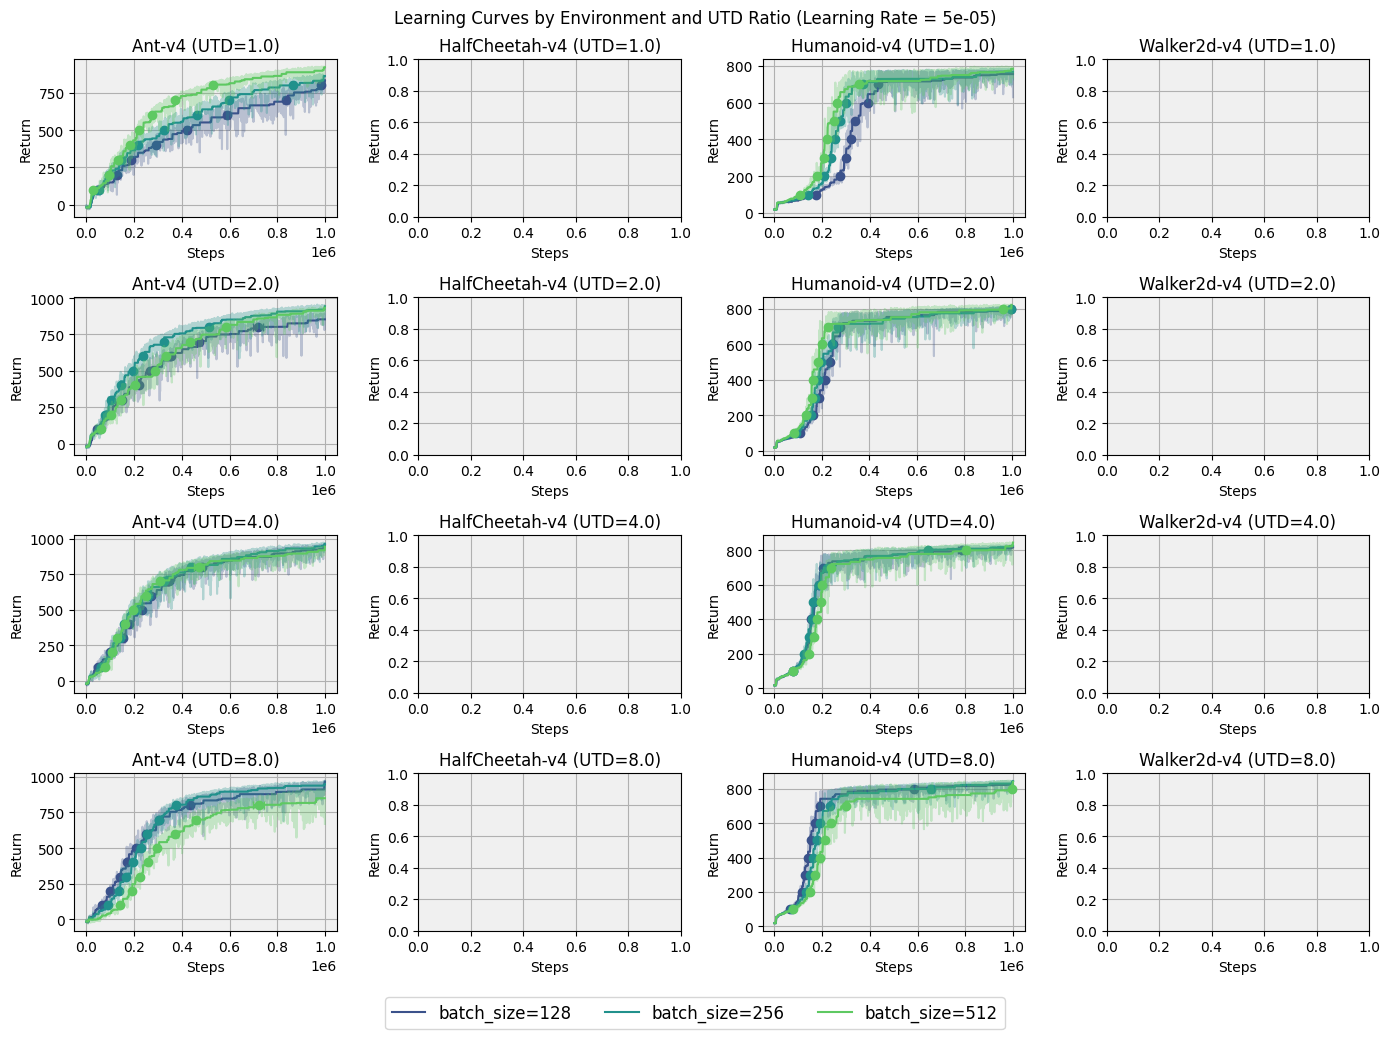

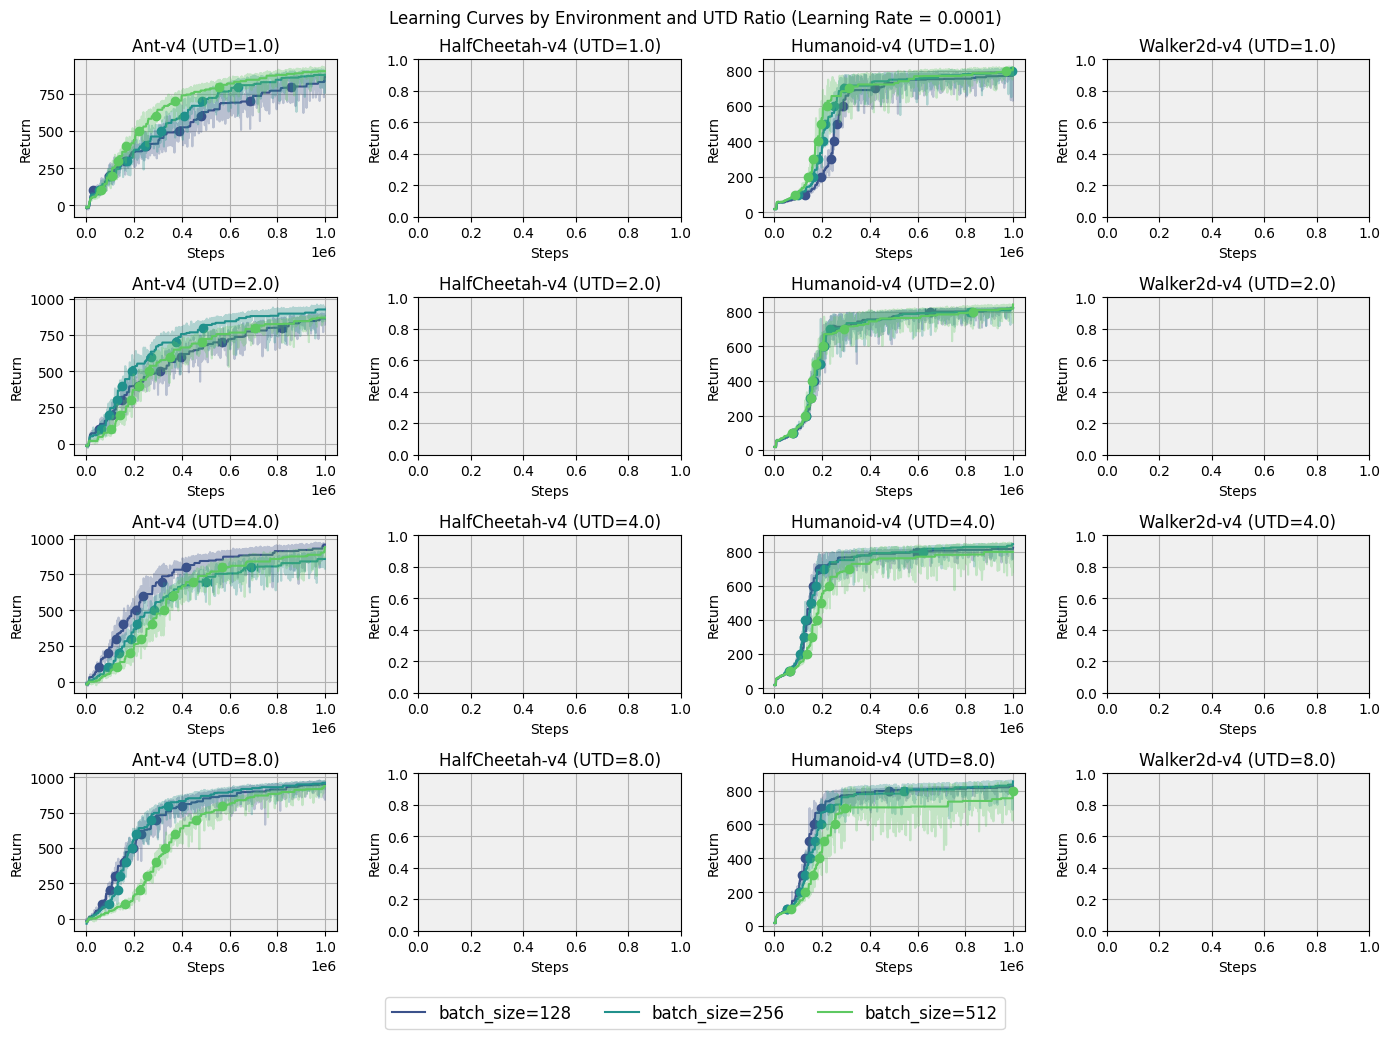

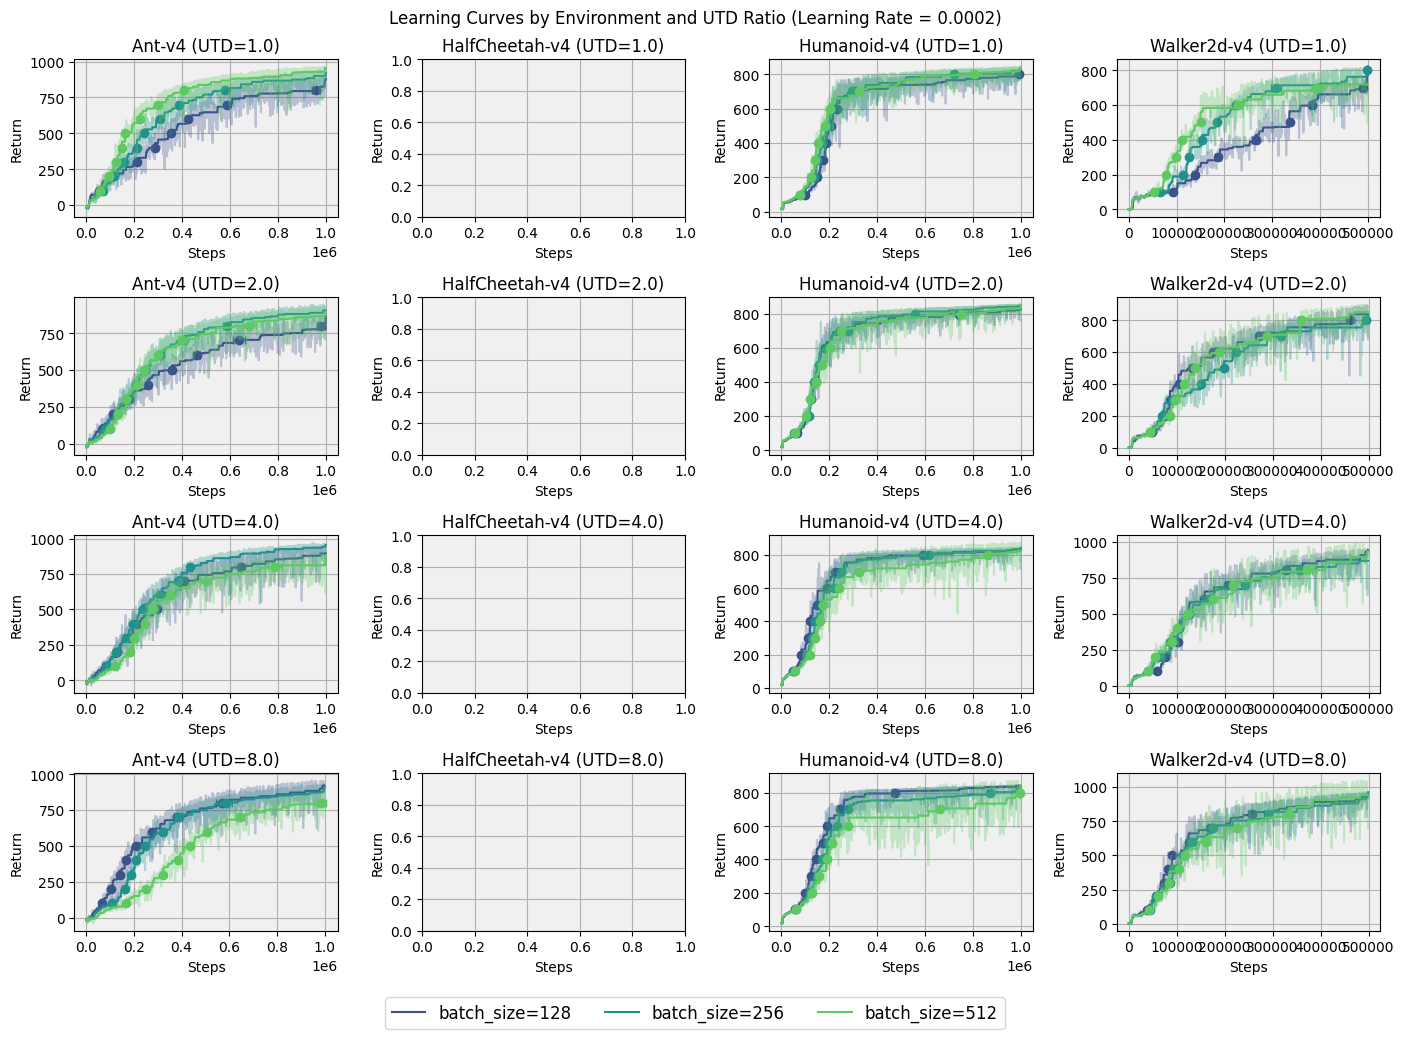

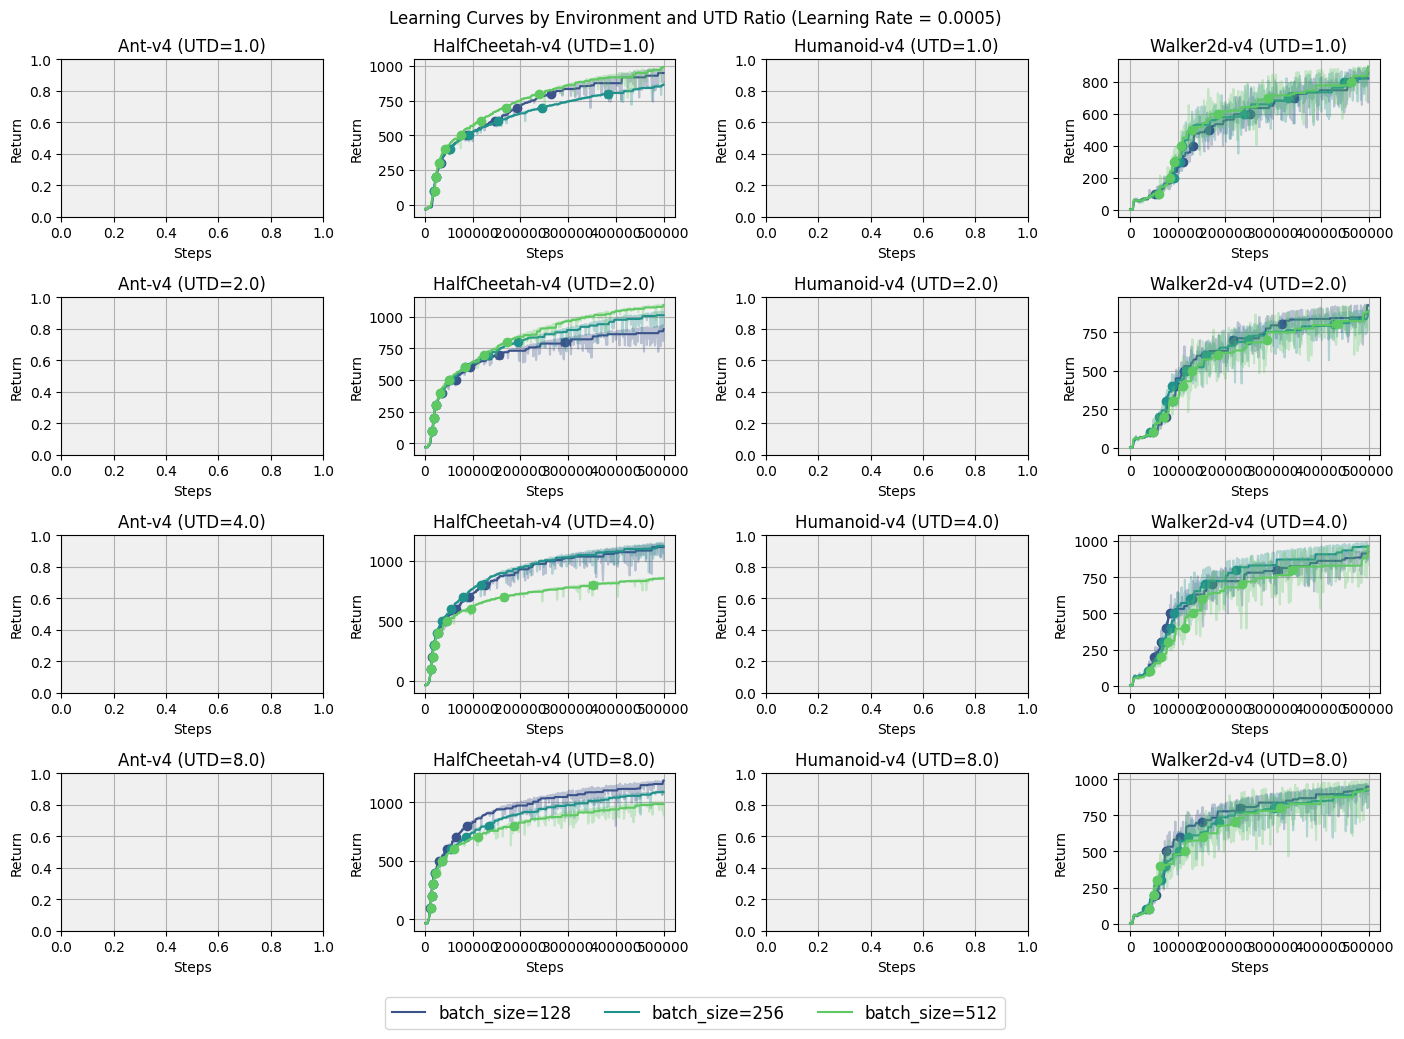

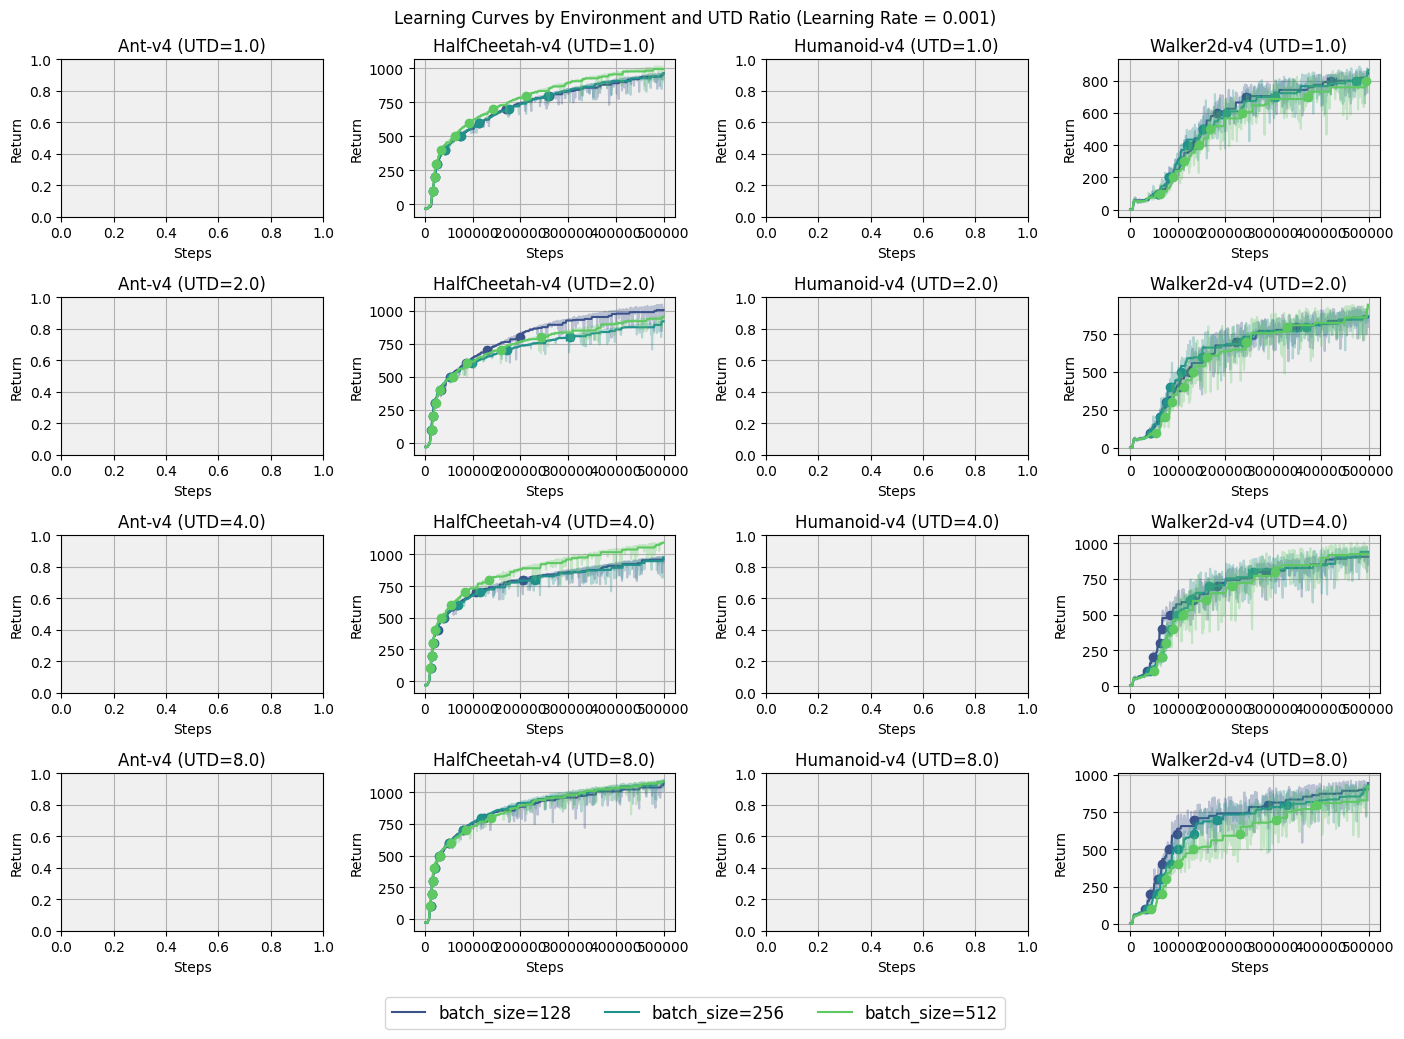

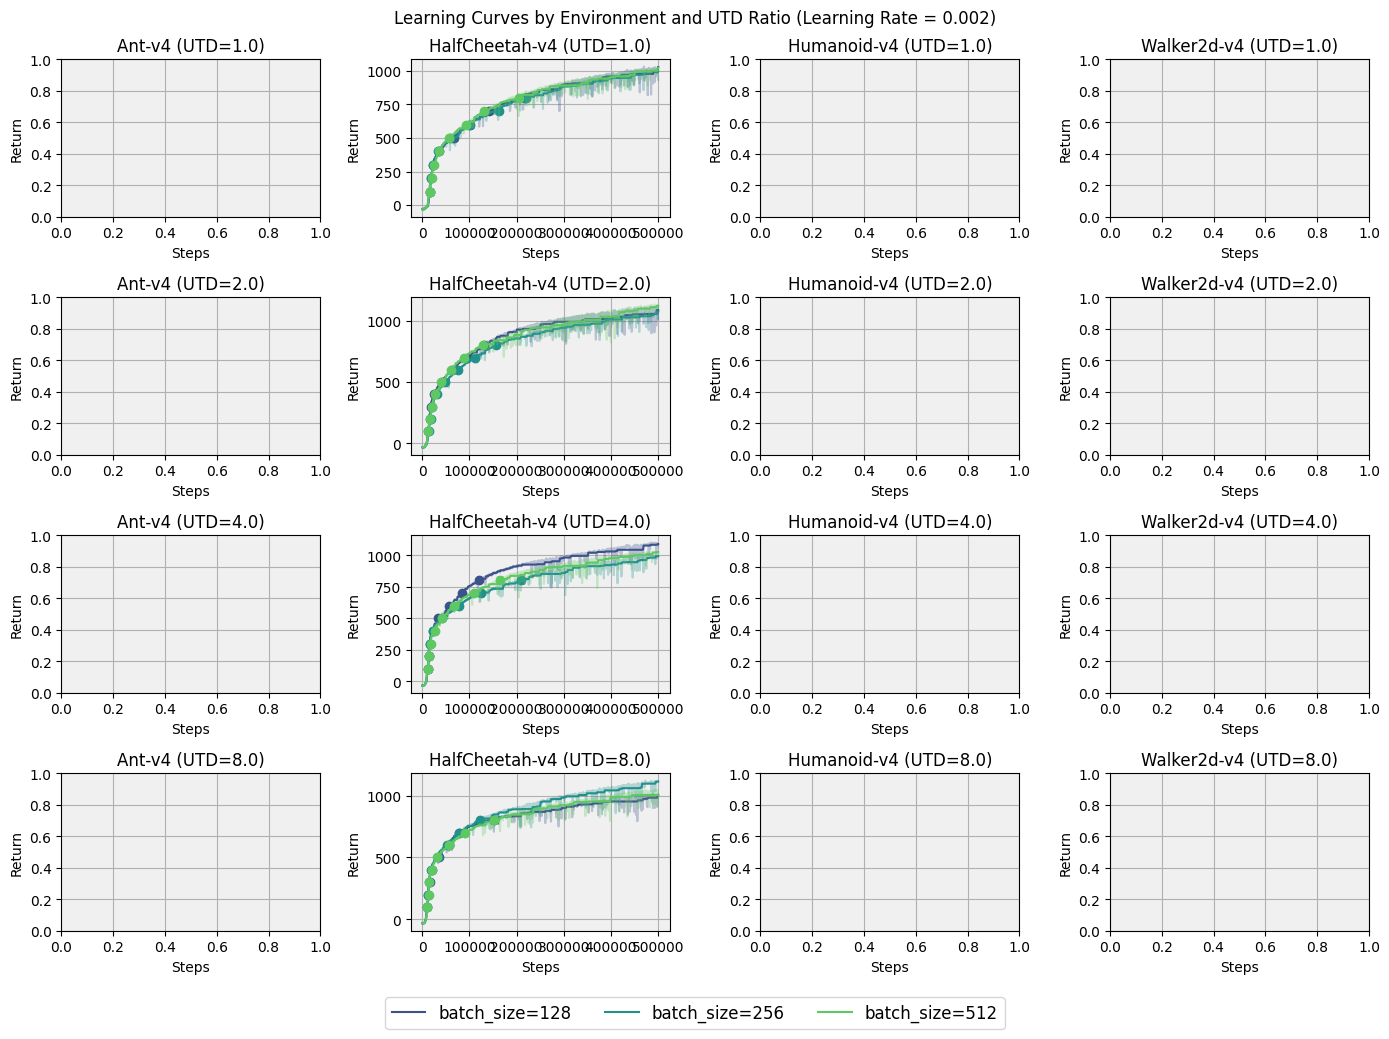

In [24]:
plot_per_learning_rate(grid_search_df, config.thresholds)

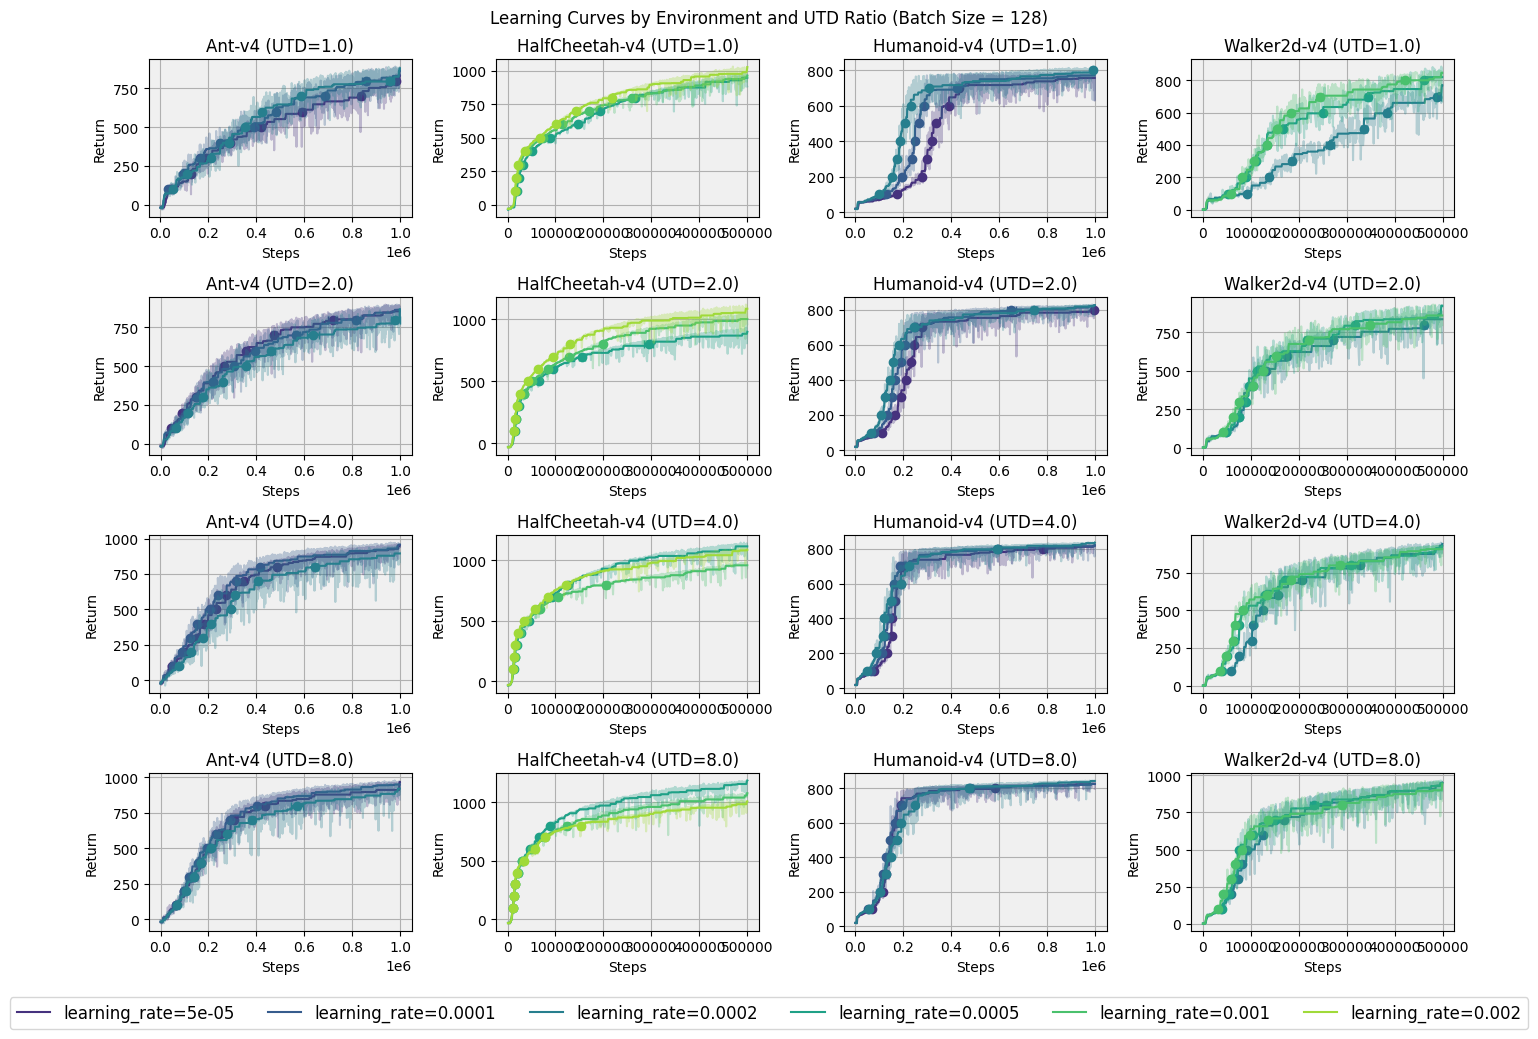

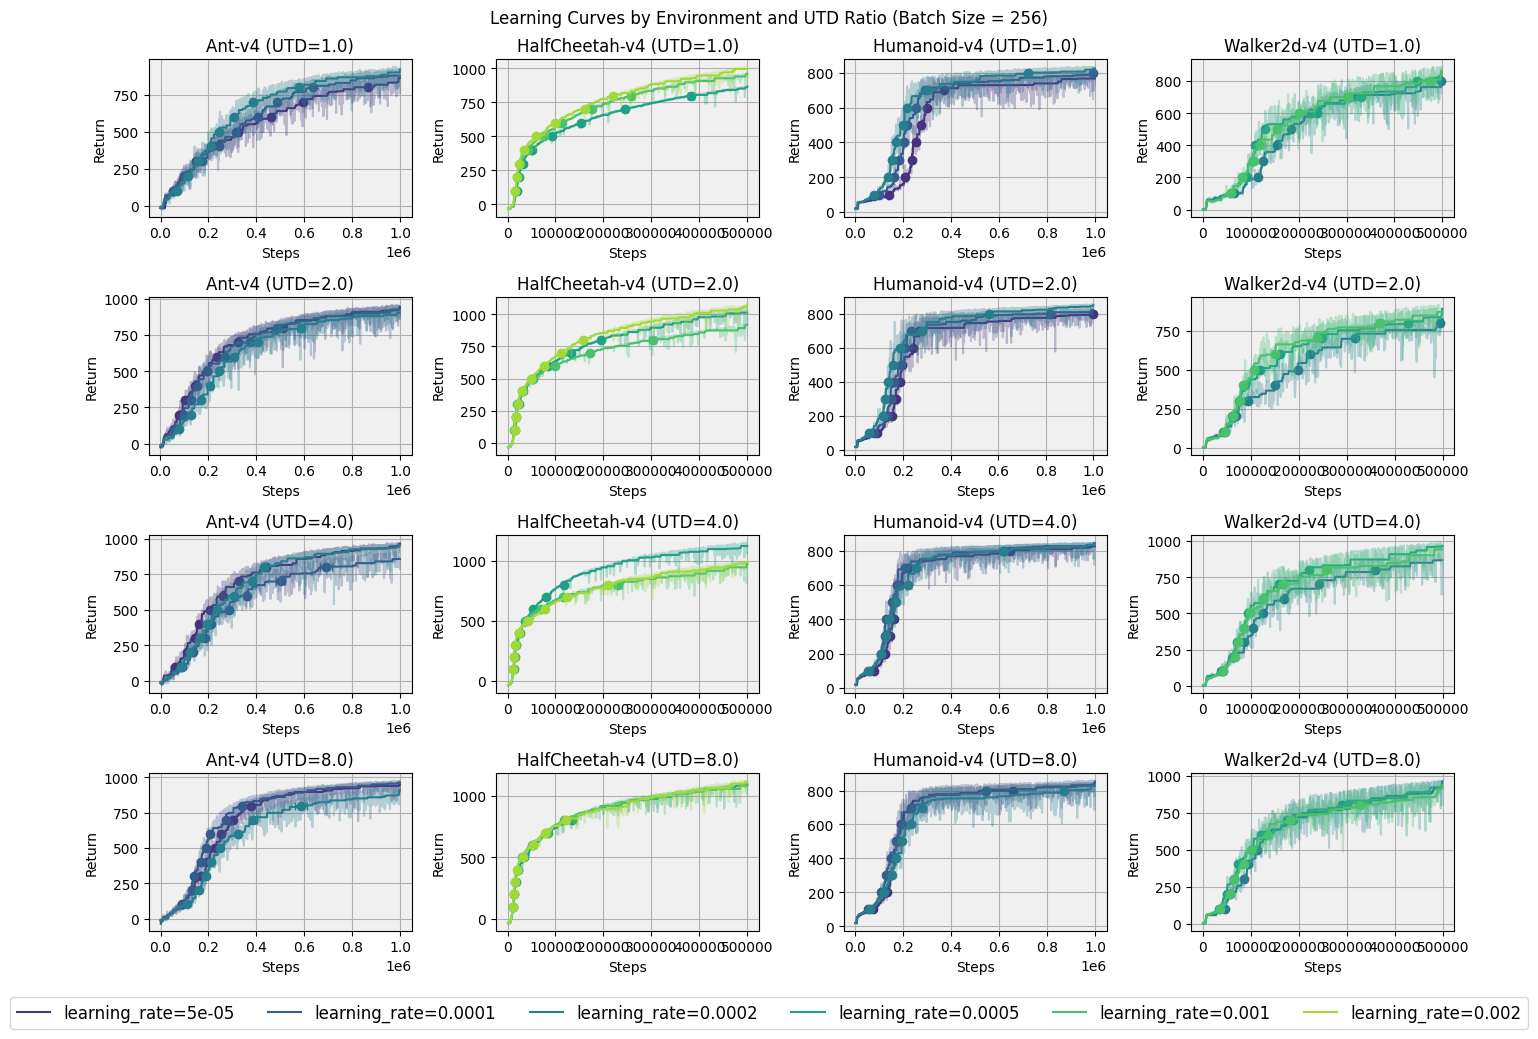

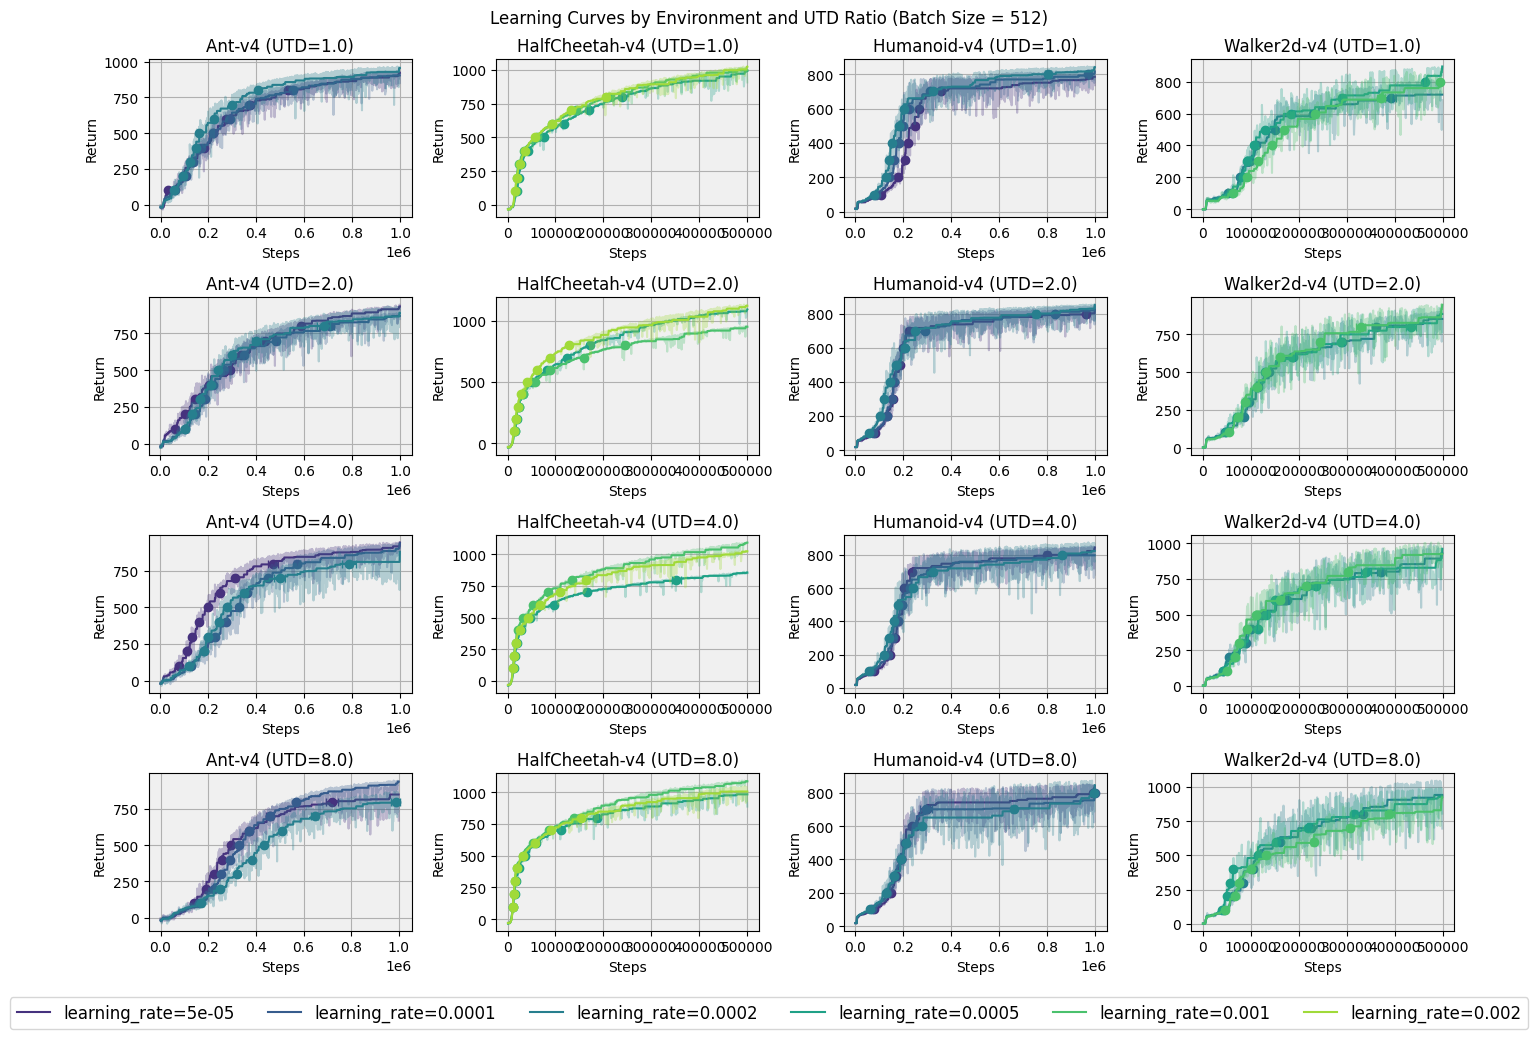

In [25]:
plot_per_batch_size(grid_search_df, config.thresholds)

# Bootstrapping

In [26]:
df_best_lr = grid_best_uncertainty_lr(grid_search_df, print_pivot=True)


Best learning_rate:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
batch_size     128     256     512            128     256     512         128     256     512         128     256     512
utd                                                                                                                      
1.0e+00    1.0e-04 2.0e-04 2.0e-04        2.0e-03 2.0e-03 2.0e-03     2.0e-04 2.0e-04 2.0e-04     1.0e-03 5.0e-04 5.0e-04
2.0e+00    5.0e-05 1.0e-04 5.0e-05        2.0e-03 2.0e-03 2.0e-03     1.0e-04 2.0e-04 2.0e-04     5.0e-04 1.0e-03 1.0e-03
4.0e+00    1.0e-04 2.0e-04 5.0e-05        2.0e-03 5.0e-04 1.0e-03     2.0e-04 2.0e-04 5.0e-05     1.0e-03 5.0e-04 1.0e-03
8.0e+00    1.0e-04 1.0e-04 1.0e-04        5.0e-04 1.0e-03 1.0e-03     2.0e-04 1.0e-04 5.0e-05     5.0e-04 2.0e-04 5.0e-04

Uncertainty-Corrected Best learning_rate:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4     

In [27]:
df_best_bs = grid_best_uncertainty_bs(grid_search_df, print_pivot=True)


Best batch_size:
env_name       Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
learning_rate 5.0e-05 1.0e-04 2.0e-04        5.0e-04 1.0e-03 2.0e-03     5.0e-05 1.0e-04 2.0e-04     2.0e-04 5.0e-04 1.0e-03
utd                                                                                                                         
1.0e+00       5.1e+02 5.1e+02 5.1e+02        5.1e+02 5.1e+02 5.1e+02         NaN 5.1e+02 2.6e+02     2.6e+02 2.6e+02 1.3e+02
2.0e+00       2.6e+02 2.6e+02 2.6e+02        5.1e+02 1.3e+02 5.1e+02     5.1e+02 1.3e+02 2.6e+02     5.1e+02 1.3e+02 5.1e+02
4.0e+00       2.6e+02 1.3e+02 2.6e+02        2.6e+02 5.1e+02 1.3e+02     2.6e+02 1.3e+02 1.3e+02     1.3e+02 2.6e+02 2.6e+02
8.0e+00       2.6e+02 2.6e+02 1.3e+02        1.3e+02 2.6e+02 2.6e+02     1.3e+02 1.3e+02 1.3e+02     1.3e+02 1.3e+02 1.3e+02

Uncertainty-Corrected Best batch_size:
env_name       Ant-v4                 HalfCheetah-v4               

In [28]:
df_best_lr_bs = df_best_lr.groupby(['env_name', 'utd']).apply(get_bootstrap_optimal, include_groups=False).reset_index()
df_best_lr_bs = compute_bootstrap_averages(df_best_lr, df_best_bs, df_best_lr_bs)

/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


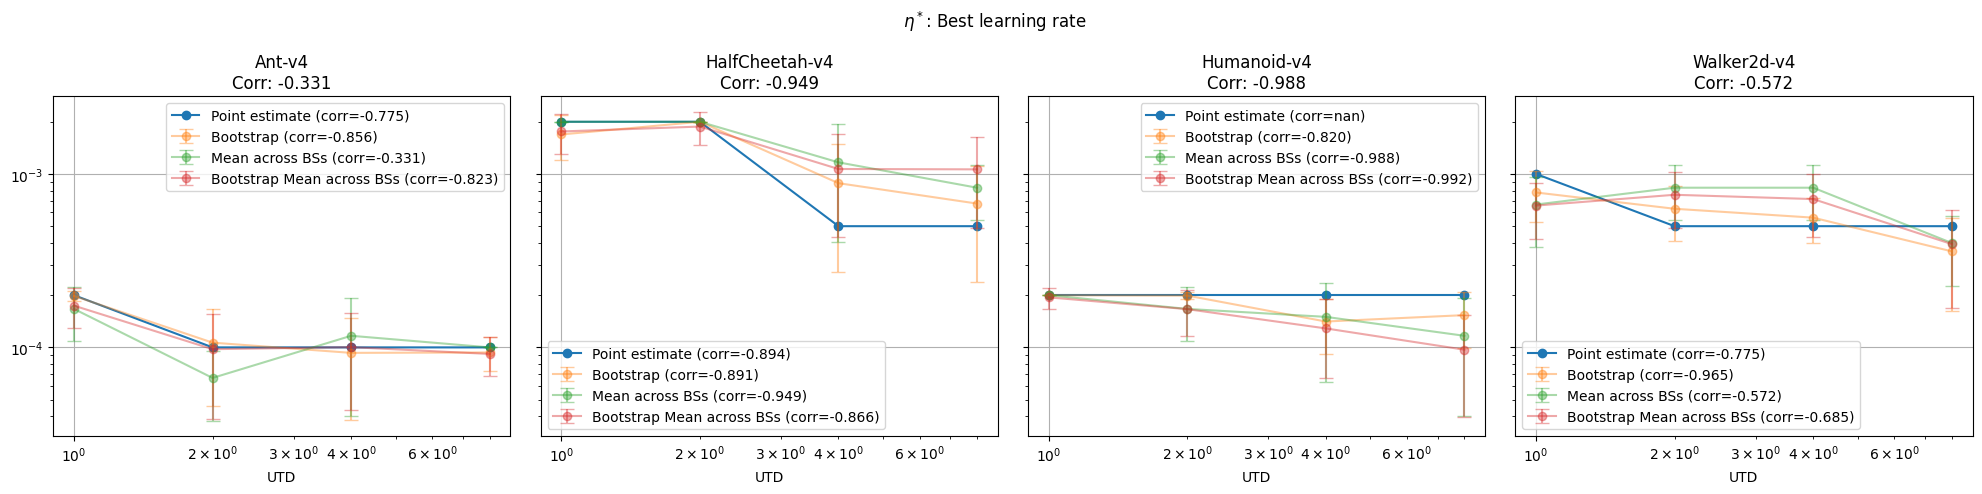

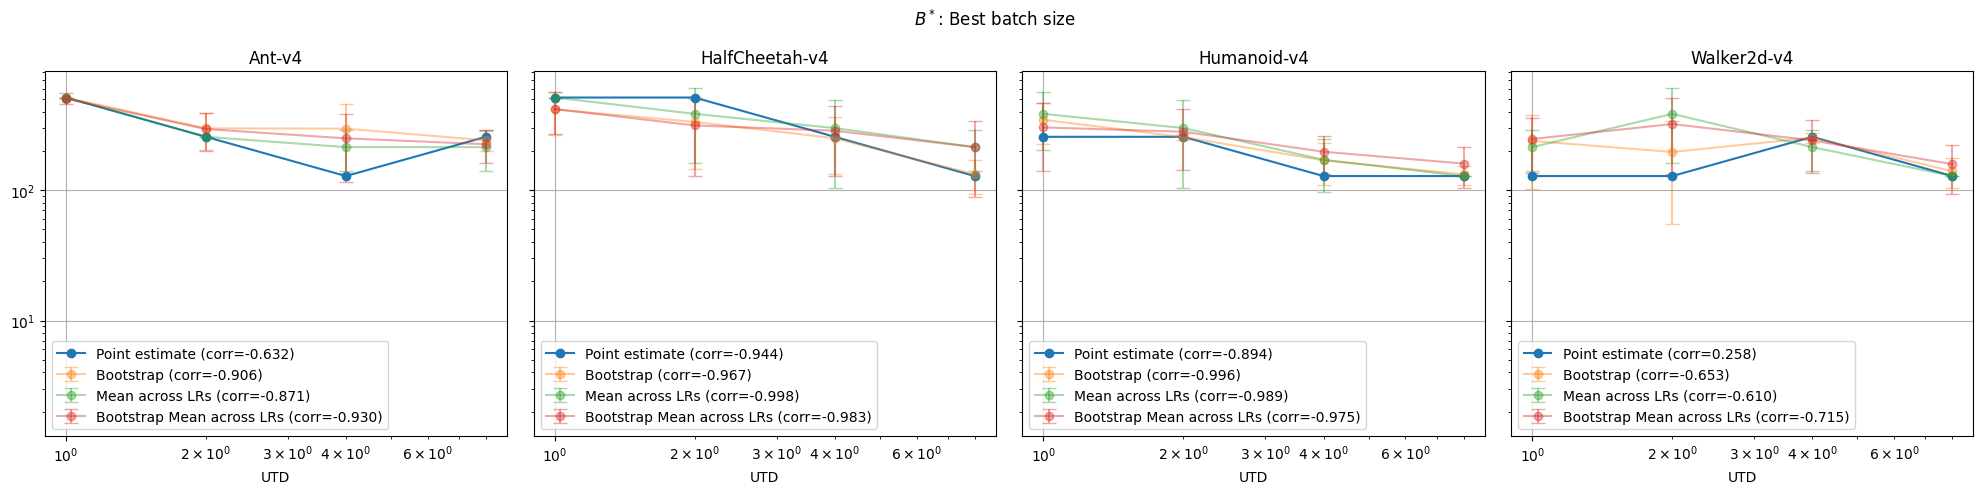

In [29]:
plot_bootstrap_average_params(df_best_lr_bs)

# Linear Fitting

Separate slope fits:
  Ant-v4:          learning rate ~ 0.000157 * UTD^-0.397143
  HalfCheetah-v4:  learning rate ~ 0.001953 * UTD^-0.359423
  Humanoid-v4:     learning rate ~ 0.000198 * UTD^-0.297448
  Walker2d-v4:     learning rate ~ 0.000680 * UTD^0.062339

  Ant-v4:          batch size ~ 472.248364 * UTD^-0.506150
  HalfCheetah-v4:  batch size ~ 404.590511 * UTD^-0.276467
  Humanoid-v4:     batch size ~ 316.325514 * UTD^-0.309491
  Walker2d-v4:     batch size ~ 270.016171 * UTD^-0.017718

Saved separate slope fits to: ../outputs/grid_proposed_fits/gym_sweep 



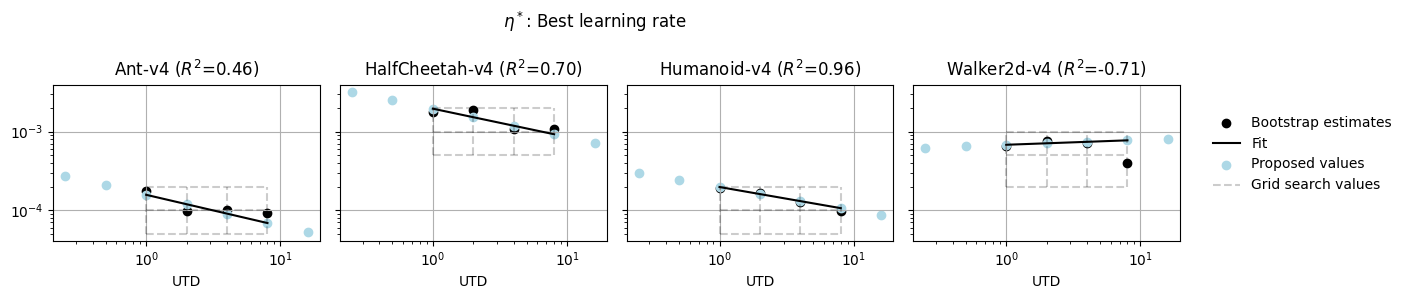

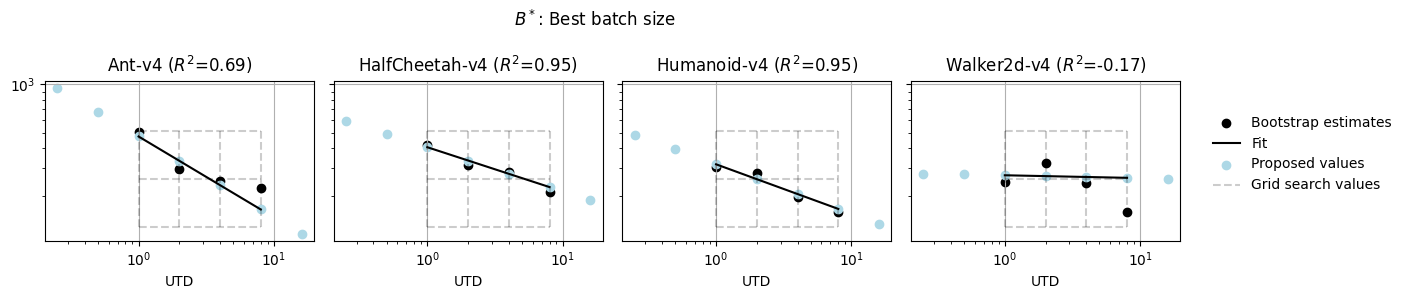

In [54]:
lr_regs_separate, bs_regs_separate = make_linear_fit_separate_slope(df_best_lr_bs, '../outputs', name)
plot_fits_against_grid_separate_slope(grid_search_df, df_best_lr_bs, config.utds_to_predict, lr_regs_separate, bs_regs_separate)

Shared slope fits:
  Ant-v4:          learning rate ~ 0.000150 * UTD^-0.284872
  HalfCheetah-v4:  learning rate ~ 0.001871 * UTD^-0.284872
  Humanoid-v4:     learning rate ~ 0.000191 * UTD^-0.284872
  Walker2d-v4:     learning rate ~ 0.000824 * UTD^-0.284872

  Ant-v4:          batch size ~ 415.838220 * UTD^-0.309609
  HalfCheetah-v4:  batch size ~ 412.012557 * UTD^-0.309609
  Humanoid-v4:     batch size ~ 313.161763 * UTD^-0.309609
  Walker2d-v4:     batch size ~ 322.787915 * UTD^-0.309609

Saved shared slope fits to: ../outputs/grid_proposed_fits/gym_sweep 



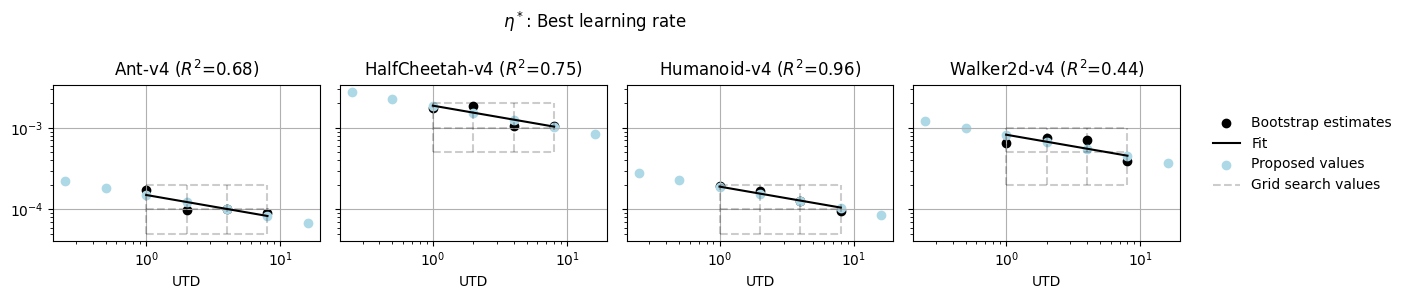

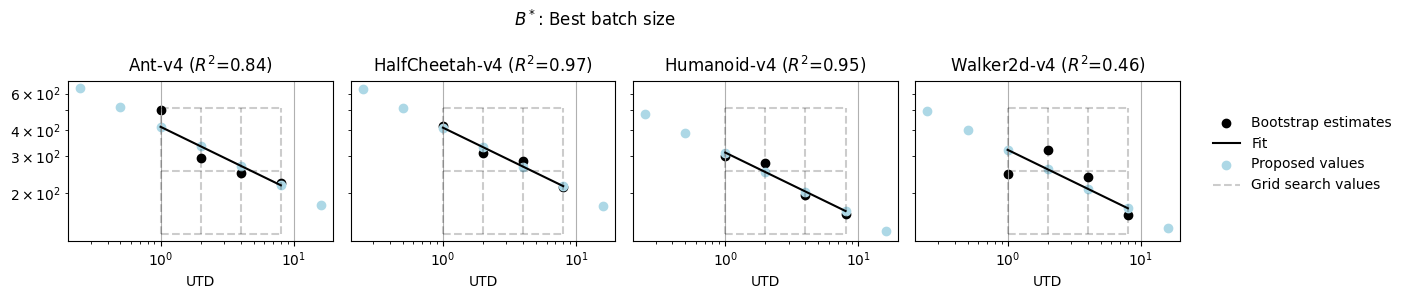

In [58]:
lr_reg_shared, bs_reg_shared = make_linear_fit_shared_slope(df_best_lr_bs, '../outputs', config.name)
plot_fits_against_grid_shared_slope(grid_search_df, df_best_lr_bs, config.utds_to_predict, lr_reg_shared, bs_reg_shared)

In [61]:
tabulate_kw = dict(
    df_grid=grid_search_df,
    utds_to_predict=config.utds_to_predict,
    outputs_dir='../outputs',
    save_path=config.name,
    verbose=False,
)

proposed_hparams_separate_slope = tabulate_proposed_hparams_separate_slope(lr_regs=lr_regs_separate, bs_regs=bs_regs_separate, **tabulate_kw)
print('Separate slope:')
display(proposed_hparams_separate_slope)

proposed_hparams_shared_slope = tabulate_proposed_hparams_shared_slope(lr_reg_shared=lr_reg_shared, bs_reg_shared=bs_reg_shared, **tabulate_kw)
print('Shared slope:')
display(proposed_hparams_shared_slope)

baseline_hparams = tabulate_baseline_hparams(**tabulate_kw)
print('Baseline:')
display(baseline_hparams)

Saved proposed hyperparameters to: ../outputs/grid_proposed_hparams/gym_sweep/separate_fitted.csv 

Separate slope:


Environment      UTD  Learning Rate  Batch Size  Learning Rate x√2  \
0           Ant-v4 2.50e-01       2.73e-04         952           3.86e-04   
1           Ant-v4 5.00e-01       2.07e-04         670           2.93e-04   
2           Ant-v4 1.00e+00       1.57e-04         472           2.22e-04   
3           Ant-v4 2.00e+00       1.19e-04         332           1.69e-04   
4           Ant-v4 4.00e+00       9.07e-05         234           1.28e-04   
5           Ant-v4 8.00e+00       6.89e-05         164           9.74e-05   
6           Ant-v4 1.60e+01       5.23e-05         116           7.40e-05   
7   HalfCheetah-v4 2.50e-01       3.21e-03         593           4.54e-03   
8   HalfCheetah-v4 5.00e-01       2.50e-03         490           3.54e-03   
9   HalfCheetah-v4 1.00e+00       1.95e-03         404           2.76e-03   
10  HalfCheetah-v4 2.00e+00       1.52e-03         334           2.15e-03   
11  HalfCheetah-v4 4.00e+00       1.19e-03         275           1.68e-03   
12  HalfCheetah-v4 8.00e+00       9.25e-04         227           1.31e-03   
13  HalfCheetah-v4 1.60e+01       7.21e-04         187           1.02e-03   
14     Humanoid-v4 2.50e-01       2.98e-04         485           4.22e-04   
15     Humanoid-v4 5.00e-01       2.43e-04         392           3.43e-04   
16     Humanoid-v4 1.00e+00       1.98e-04         316           2.79e-04   
17     Humanoid-v4 2.00e+00       1.61e-04         255           2.27e-04   
18     Humanoid-v4 4.00e+00       1.31e-04         205           1.85e-04   
19     Humanoid-v4 8.00e+00       1.06e-04         166           1.51e-04   
20     Humanoid-v4 1.60e+01       8.66e-05         134           1.22e-04   
21     Walker2d-v4 2.50e-01       6.23e-04         276           8.82e-04   
22     Walker2d-v4 5.00e-01       6.51e-04         273           9.21e-04   
23     Walker2d-v4 1.00e+00       6.80e-04         270           9.61e-04   
24     Walker2d-v4 2.00e+00       7.10e-04         266           1.00e-03   
25     Walker2d-v4 4.00e+00       7.41e-04         263           1.05e-03   
26     Walker2d-v4 8.00e+00       7.74e-04         260           1.09e-03   
27     Walker2d-v4 1.60e+01       8.08e-04         257           1.14e-03   

    Learning Rate x√0.5  Batch Size x√2  Batch Size x√0.5  \
0              1.93e-04            1347               673   
1              1.46e-04             948               474   
2              1.11e-04             667               333   
3              8.45e-05             470               235   
4              6.41e-05             331               165   
5              4.87e-05             233               116   
6              3.70e-05             164                82   
7              2.27e-03             839               419   
8              1.77e-03             693               346   
9              1.38e-03             572               286   
10             1.08e-03             472               236   
11             8.39e-04             390               195   
12             6.54e-04             322               161   
13             5.10e-04             265               132   
14             2.11e-04             687               343   
15             1.72e-04             554               277   
16             1.40e-04             447               223   
17             1.14e-04             360               180   
18             9.25e-05             291               145   
19             7.53e-05             235               117   
20             6.12e-05             189                94   
21             4.41e-04             391               195   
22             4.60e-04             386               193   
23             4.81e-04             381               190   
24             5.02e-04             377               188   
25             5.24e-04             372               186   
26             5.47e-04             368               184   
27             5.71e-04             363               181   

   

Saved proposed hyperparameters to: ../outputs/grid_proposed_hparams/gym_sweep/shared_fitted.csv 

Shared slope:


Environment      UTD  Learning Rate  Batch Size  Learning Rate x√2  \
0           Ant-v4 2.50e-01       2.23e-04         638           3.16e-04   
1           Ant-v4 5.00e-01       1.83e-04         515           2.59e-04   
2           Ant-v4 1.00e+00       1.50e-04         415           2.13e-04   
3           Ant-v4 2.00e+00       1.23e-04         335           1.75e-04   
4           Ant-v4 4.00e+00       1.01e-04         270           1.43e-04   
5           Ant-v4 8.00e+00       8.31e-05         218           1.18e-04   
6           Ant-v4 1.60e+01       6.82e-05         176           9.65e-05   
7   HalfCheetah-v4 2.50e-01       2.78e-03         632           3.93e-03   
8   HalfCheetah-v4 5.00e-01       2.28e-03         510           3.22e-03   
9   HalfCheetah-v4 1.00e+00       1.87e-03         412           2.65e-03   
10  HalfCheetah-v4 2.00e+00       1.54e-03         332           2.17e-03   
11  HalfCheetah-v4 4.00e+00       1.26e-03         268           1.78e-03   
12  HalfCheetah-v4 8.00e+00       1.03e-03         216           1.46e-03   
13  HalfCheetah-v4 1.60e+01       8.49e-04         174           1.20e-03   
14     Humanoid-v4 2.50e-01       2.83e-04         481           4.00e-04   
15     Humanoid-v4 5.00e-01       2.32e-04         388           3.28e-04   
16     Humanoid-v4 1.00e+00       1.91e-04         313           2.69e-04   
17     Humanoid-v4 2.00e+00       1.56e-04         252           2.21e-04   
18     Humanoid-v4 4.00e+00       1.28e-04         203           1.82e-04   
19     Humanoid-v4 8.00e+00       1.05e-04         164           1.49e-04   
20     Humanoid-v4 1.60e+01       8.65e-05         132           1.22e-04   
21     Walker2d-v4 2.50e-01       1.22e-03         495           1.73e-03   
22     Walker2d-v4 5.00e-01       1.00e-03         400           1.42e-03   
23     Walker2d-v4 1.00e+00       8.24e-04         322           1.17e-03   
24     Walker2d-v4 2.00e+00       6.76e-04         260           9.56e-04   
25     Walker2d-v4 4.00e+00       5.55e-04         210           7.85e-04   
26     Walker2d-v4 8.00e+00       4.56e-04         169           6.44e-04   
27     Walker2d-v4 1.60e+01       3.74e-04         136           5.29e-04   

    Learning Rate x√0.5  Batch Size x√2  Batch Size x√0.5  \
0              1.58e-04             903               451   
1              1.30e-04             728               364   
2              1.06e-04             588               294   
3              8.73e-05             474               237   
4              7.16e-05             382               191   
5              5.88e-05             308               154   
6              4.83e-05             249               124   
7              1.96e-03             895               447   
8              1.61e-03             722               361   
9              1.32e-03             582               291   
10             1.09e-03             470               235   
11             8.91e-04             379               189   
12             7.32e-04             306               153   
13             6.01e-04             246               123   
14             2.00e-04             680               340   
15             1.64e-04             548               274   
16             1.35e-04             442               221   
17             1.11e-04             357               178   
18             9.08e-05             288               144   
19             7.45e-05             232               116   
20             6.12e-05             187                93   
21             8.65e-04             701               350   
22             7.10e-04             565               282   
23             5.83e-04             456               228   
24             4.78e-04             368               184   
25             3.93e-04             297               148   
26             3.22e-04             239               119   
27             2.64e-04             193                96   

   

Baseline based optimal hyperparamers at UTD 2.0 

Saved baseline hyperparameters to: ../outputs/grid_proposed_hparams/gym_sweep/baseline_utd2.0.csv 

Baseline:


Environment      UTD  Learning Rate  Batch Size  is_new_experiment
0           Ant-v4 2.50e-01       1.00e-04         256               True
1           Ant-v4 5.00e-01       1.00e-04         256               True
2           Ant-v4        1       1.00e-04         256              False
3           Ant-v4        2       1.00e-04         256              False
4           Ant-v4        4       1.00e-04         256              False
5           Ant-v4        8       1.00e-04         256              False
6           Ant-v4       16       1.00e-04         256               True
7   HalfCheetah-v4 2.50e-01       2.00e-03         512               True
8   HalfCheetah-v4 5.00e-01       2.00e-03         512               True
9   HalfCheetah-v4        1       2.00e-03         512              False
10  HalfCheetah-v4        2       2.00e-03         512              False
11  HalfCheetah-v4        4       2.00e-03         512              False
12  HalfCheetah-v4        8       2.00e-03         512              False
13  HalfCheetah-v4       16       2.00e-03         512               True
14     Humanoid-v4 2.50e-01       2.00e-04         256               True
15     Humanoid-v4 5.00e-01       2.00e-04         256               True
16     Humanoid-v4        1       2.00e-04         256              False
17     Humanoid-v4        2       2.00e-04         256              False
18     Humanoid-v4        4       2.00e-04         256              False
19     Humanoid-v4        8       2.00e-04         256              False
20     Humanoid-v4       16       2.00e-04         256               True
21     Walker2d-v4 2.50e-01       5.00e-04         128               True
22     Walker2d-v4 5.00e-01       5.00e-04         128               True
23     Walker2d-v4        1       5.00e-04         128              False
24     Walker2d-v4        2       5.00e-04         128              False
25     Walker2d-v4        4       5.00e-04         128              False
26     Walker2d-v4        8       5.00e-04         128              False
27     Walker2d-v4       16       5.00e-04         128               True

In [ ]:
proposed_values_df

Environment      UTD  Learning Rate  Learning Rate x√2  \
0           Ant-v4 2.50e-01       2.23e-04           3.16e-04   
1           Ant-v4 5.00e-01       1.83e-04           2.59e-04   
2           Ant-v4 1.00e+00       1.50e-04           2.13e-04   
3           Ant-v4 2.00e+00       1.23e-04           1.75e-04   
4           Ant-v4 4.00e+00       1.01e-04           1.43e-04   
5           Ant-v4 8.00e+00       8.31e-05           1.18e-04   
6           Ant-v4 1.60e+01       6.82e-05           9.65e-05   
7   HalfCheetah-v4 2.50e-01       2.78e-03           3.93e-03   
8   HalfCheetah-v4 5.00e-01       2.28e-03           3.22e-03   
9   HalfCheetah-v4 1.00e+00       1.87e-03           2.65e-03   
10  HalfCheetah-v4 2.00e+00       1.54e-03           2.17e-03   
11  HalfCheetah-v4 4.00e+00       1.26e-03           1.78e-03   
12  HalfCheetah-v4 8.00e+00       1.03e-03           1.46e-03   
13  HalfCheetah-v4 1.60e+01       8.49e-04           1.20e-03   
14     Humanoid-v4 2.50e-01       2.83e-04           4.00e-04   
15     Humanoid-v4 5.00e-01       2.32e-04           3.28e-04   
16     Humanoid-v4 1.00e+00       1.91e-04           2.69e-04   
17     Humanoid-v4 2.00e+00       1.56e-04           2.21e-04   
18     Humanoid-v4 4.00e+00       1.28e-04           1.82e-04   
19     Humanoid-v4 8.00e+00       1.05e-04           1.49e-04   
20     Humanoid-v4 1.60e+01       8.65e-05           1.22e-04   
21     Walker2d-v4 2.50e-01       1.22e-03           1.73e-03   
22     Walker2d-v4 5.00e-01       1.00e-03           1.42e-03   
23     Walker2d-v4 1.00e+00       8.24e-04           1.17e-03   
24     Walker2d-v4 2.00e+00       6.76e-04           9.56e-04   
25     Walker2d-v4 4.00e+00       5.55e-04           7.85e-04   
26     Walker2d-v4 8.00e+00       4.56e-04           6.44e-04   
27     Walker2d-v4 1.60e+01       3.74e-04           5.29e-04   

    Learning Rate x√0.5  Batch Size  Batch Size x√2  Batch Size x√0.5  \
0              1.58e-04         639             903               452   
1              1.30e-04         515             729               364   
2              1.06e-04         416             588               294   
3              8.73e-05         336             475               237   
4              7.16e-05         271             383               191   
5              5.88e-05         218             309               154   
6              4.83e-05         176             249               125   
7              1.96e-03         633             895               448   
8              1.61e-03         511             722               361   
9              1.32e-03         412             583               291   
10             1.09e-03         332             470               235   
11             8.91e-04         268             379               190   
12             7.32e-04         216             306               153   
13             6.01e-04         175             247               123   
14             2.00e-04         481             680               340   
15             1.64e-04         388             549               274   
16             1.35e-04         313             443               221   
17             1.11e-04         253             357               179   
18             9.08e-05         204             288               144   
19             7.45e-05         164             233               116   
20             6.12e-05         133             188                94   
21             8.65e-04         496             701               351   
22             7.10e-04         400             566               283   
23             5.83e-04         323             456               228   
24             4.78e-04         260             368               184   
25             3.93e-04         210             297               149   
26             3.22e-04         170             240               120   
27             2.64e-04         137             193                97   

   

# Data Efficiency

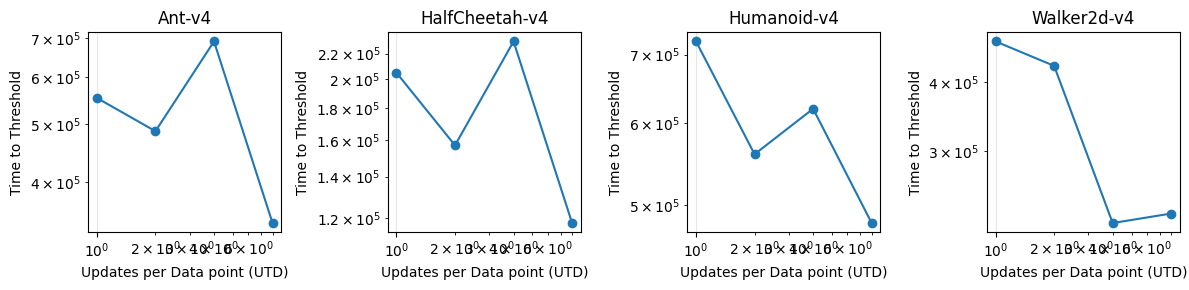

In [66]:
closest_fit_steps_per_utd = plot_closest_data_efficiency(grid_search_df, proposed_hparams_shared_slope)

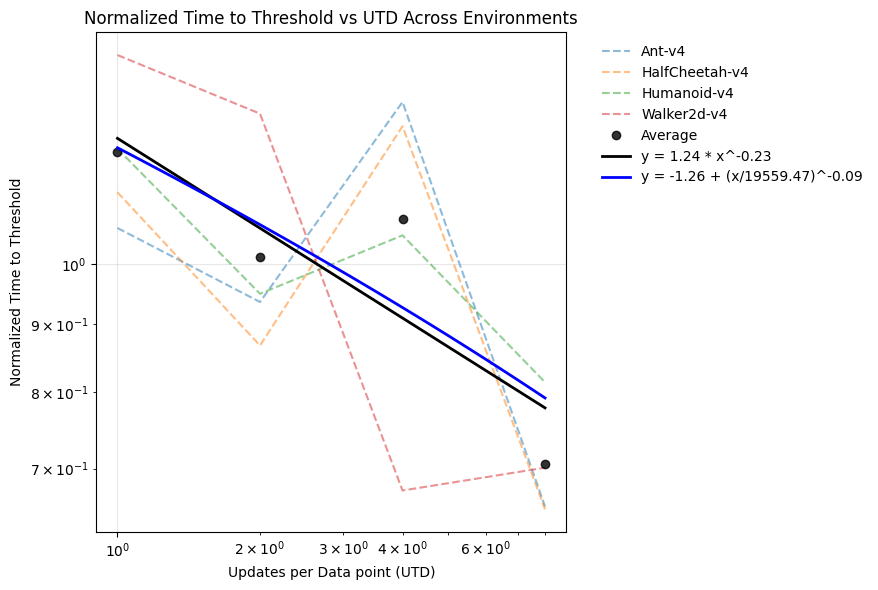

In [69]:
plot_averaged_data_efficiency(closest_fit_steps_per_utd)